In [14]:
import openeo
import requests

base_url = "http://127.0.0.1:8081/"



Authenticated using refresh token.


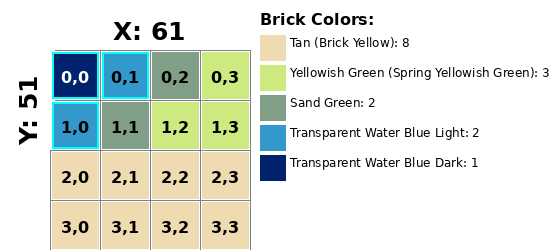

In [15]:
# Connect to the back-end
connection = openeo.connect(base_url)
# ToDo: Here you need to authenticate with authenticate_basic() or authenticate_oidc()
connection.authenticate_oidc()

claim_service_id = "12846e5b-6769-401b-877d-d8727a92ccf8"
zoom_level = 7
token = connection.auth.bearer

# call the service with the token
response = requests.get(
    f"{base_url}/services/xyz/{claim_service_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

# Display the tile in the notebook inline
if response.status_code == 200:
    with open("tile.png", "wb") as f:
        f.write(response.content)

    from PIL import Image
    from IPython.display import display

    img = Image.open("tile.png")
    display(img)

else:
    print("Error:", response.status_code)
    print(response.text)


In [ ]:
release_service_id = "2818bbc0-8aee-4acf-a0b3-bba94506d172"
zoom_level = 7
token = connection.auth.bearer

# call the service with the token
response = requests.get(
    f"{base_url}/services/xyz/{release_service_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

# Display the text in the notebook inline
if response.status_code == 200:
    print(response.text)
else:
    print("Error:", response.status_code)
    print(response.text)